In [93]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import json 
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm
from numba import cuda
from peft import LoraConfig
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorWithPadding

In [94]:
try:
    connection = pymysql.connect(
        host='retn0.iptime.org',
        port=3306,
        user='communav',
        password='0D9O2nhyjBhBofrCbQkHZcwnIifJkCjP',
        database='communav'
    )
    print('Successfully connected to DB.')
except:
    print(f'Failed to connect to DB. ')

Successfully connected to DB.


In [95]:
cursor = connection.cursor()

cursor.execute('''
    SELECT
        articles.id,
        articles.title,
        articles.text,
        articles.category_id
    FROM everytime_article_dataset_v1 as articles
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')
# print(original_articles)

cursor.close()
connection.close()

Loaded 299314 articles.


In [101]:
# 전처리
datasets = []
original_articles = pd.DataFrame(original_articles)
original_articles.columns = ['id' , 'title', 'text', 'category_ids']
# print(original_articles)

NotNandatasets = original_articles[pd.notna(original_articles['category_ids'])]
    
for i in range(14):
    # if i == 0: continue
    datasets.append(pd.DataFrame([(article['title'] + article['text'] , 1) if i == int(article['category_ids']) else (article['title'] + article['text'] , 0) for k, article in NotNandatasets.iterrows()] ))
    datasets[i].columns = ['content', 'label']
    
for i in range(14):
    true_label = [(data.content, data.label) for data in datasets[i].itertuples() if data.label == 1]
    false_label = [(data.content, data.label) for data in datasets[i].itertuples() if data.label == 0]
    # false_label = false_label[:len(true_label) * 5]
    true_label.extend(false_label)
    datasets[i] = pd.DataFrame(true_label, columns=['content', 'label'])

In [102]:
def plot_distribution(articles):
    label_counts = [0, 0]
    for article in articles.itertuples():
        label_counts[article.label] += 1

    total_count = sum(label_counts)
    percentages = [count / total_count * 100 for count in label_counts]
    for i, percentage in enumerate(percentages):
        print(f'Label {i}: {percentage:.2f}%')

    plt.figure(figsize=(8, 6))
    plt.bar(['0', '1'], label_counts)
    plt.text(0, label_counts[0] + 0.1, str(label_counts[0]), ha='center')
    plt.text(1, label_counts[1] + 0.1, str(label_counts[1]), ha='center')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

Label 0: 96.80%
Label 1: 3.20%


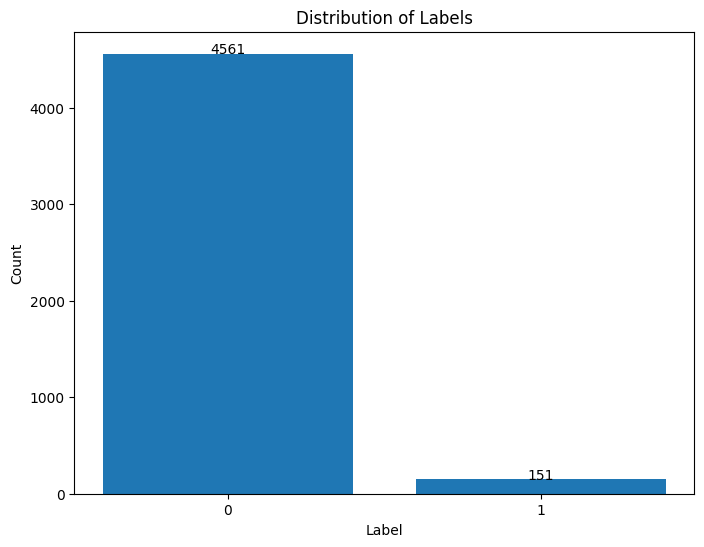

In [106]:
# datasets[1].columns = ['content', 'label']
# df = pd.DataFrame(datasets[1], columns=['content', 'label'])
plot_distribution(datasets[12])

In [107]:
MODEL_ID = 'beomi/KcELECTRA-base-v2022'
MAX_LENGTH = 128
F_BETA = 0.5
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 2e-5
SAVE_PATH = r"C:\Users\USER\Desktop\model2"

In [108]:
# 각 라벨링 별 train, test set 생성
train_val_sets = []
for i in range(14):
    train_articles, val_articles = train_test_split( datasets[i], test_size=0.2, random_state=42 )
    train_val_sets.append((train_articles, val_articles))

In [109]:
def make_dataset(category_id):
    train_articles, val_articles = train_val_sets[category_id]
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # train_articles = train_articles[:len(val_articles)]
    train_contents = [article.content for article in train_articles.itertuples()]
    train_labels = [article.label for article in train_articles.itertuples()]
    val_contents = [article.content for article in val_articles.itertuples()]
    val_labels = [article.label for article in val_articles.itertuples()]

    class CustomDataset(Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_encodings = tokenizer(
        train_contents,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=MAX_LENGTH
    )
    val_encodings = tokenizer(
        val_contents,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=MAX_LENGTH
    )

    train_dataset = CustomDataset(train_encodings, train_labels)
    val_dataset = CustomDataset(val_encodings, val_labels)
    # train_dataset = torch.utils.data.TensorDataset(
        # train_encodings['input_ids'],
        # train_encodings['attention_mask'],
        # torch.tensor(train_labels)
    # )
    # val_dataset = torch.utils.data.TensorDataset(
        # val_encodings['input_ids'],
        # val_encodings['attention_mask'],
        # torch.tensor(val_labels)
    # )

    # train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_dataset, val_dataset, data_collator, tokenizer

In [110]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)
    f_beta = fbeta_score(labels, predictions, beta=F_BETA)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f_beta": f_beta
    }

In [111]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3050


In [112]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
model.to(device)

# 모든 파라미터를 고정
for param in model.parameters():
    param.requires_grad = False

# 마지막 레이어의 파라미터만 학습 가능하도록 설정
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model's state_dict:
electra.embeddings.word_embeddings.weight 	 torch.Size([54343, 768])
electra.embeddings.position_embeddings.weight 	 torch.Size([512, 768])
electra.embeddings.token_type_embeddings.weight 	 torch.Size([2, 768])
electra.embeddings.LayerNorm.weight 	 torch.Size([768])
electra.embeddings.LayerNorm.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
electra.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
electra.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
electra.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
electra.encoder.layer.0.attention.output.dense.bias 	 torch.Size([768])
electra.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size(

In [113]:
metrics_rst = []

target_modules = "query,value,output.dense,intermediate.dense,classifier.dense,classifier.out_proj".split(",")
lora_config = LoraConfig(
        r=16,  # 업데이트 행렬의 순위로, 정수로 표현됩니다. 낮은 순위는 더 적은 학습 가능한 파라미터를 가진 작은 업데이트 행렬을 생성합니다.
        lora_alpha=32,  # LoRA 스케일링 팩터입니다.
        target_modules=target_modules,
        lora_dropout=0.05,  
        bias="none", 
        task_type="CAUSAL_LM" 
        )


for id in range(0, 14):
    train_datasets, val_datasets, data_collator, tokenizer = make_dataset(id)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
    # model.to(device)
    model_path = SAVE_PATH + f'\model-with-LoRA-category-id-' + str(id) + '-LoRA-adaptors'

    # model = prepare_model_for_kbit_training(model)
 
    # add LoRA adaptor
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    # Define training args
    training_args = TrainingArguments(
        output_dir=SAVE_PATH,
        per_device_train_batch_size=16,  
        per_device_eval_batch_size=16,
        learning_rate=LEARNING_RATE, 
        num_train_epochs=12,
        logging_dir=f"{SAVE_PATH}/logs",
        logging_strategy="steps",
        logging_steps=50,
        save_strategy="steps",
        report_to="tensorboard",
        evaluation_strategy="steps",
        eval_steps=50,
        save_total_limit=1,
        load_best_model_at_end=True,
    )
 
    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_datasets,
        eval_dataset=val_datasets,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    lora_weights = {name: param for name, param in model.named_parameters() if 'lora' in name}
    torch.save(lora_weights, model_path)

    # torch.save(model.lora.state_dict(), model_path)

        
print('Training finished.')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.665000,0.551411,0.892895,1.000000,0.009804,0.047170
100,0.431900,0.341312,0.891835,0.000000,0.000000,0.000000
150,0.295100,0.311107,0.891835,0.000000,0.000000,0.000000
200,0.302500,0.300179,0.891835,0.000000,0.000000,0.000000
250,0.282000,0.291513,0.891835,0.000000,0.000000,0.000000
300,0.265100,0.276998,0.891835,0.000000,0.000000,0.000000
350,0.246700,0.261594,0.891835,0.000000,0.000000,0.000000
400,0.215000,0.242546,0.891835,0.000000,0.000000,0.000000
450,0.224900,0.213760,0.891835,0.000000,0.000000,0.000000
500,0.184000,0.188328,0.891835,0.000000,0.000000,0.000000


C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\L

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.613200,0.524058,0.910923,0.000000,0.000000,0.000000
100,0.395700,0.331793,0.910923,0.000000,0.000000,0.000000
150,0.273800,0.305201,0.910923,0.000000,0.000000,0.000000
200,0.273200,0.305297,0.910923,0.000000,0.000000,0.000000
250,0.263700,0.305503,0.910923,0.000000,0.000000,0.000000
300,0.287000,0.297511,0.910923,0.000000,0.000000,0.000000
350,0.219800,0.306969,0.910923,0.000000,0.000000,0.000000
400,0.225800,0.300455,0.910923,0.000000,0.000000,0.000000
450,0.249700,0.285653,0.910923,0.000000,0.000000,0.000000
500,0.226400,0.281707,0.910923,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.651700,0.600271,0.792153,0.000000,0.000000,0.000000
100,0.537300,0.514522,0.792153,0.000000,0.000000,0.000000
150,0.479000,0.505511,0.792153,0.000000,0.000000,0.000000
200,0.472100,0.498920,0.792153,0.000000,0.000000,0.000000
250,0.482300,0.484573,0.792153,0.000000,0.000000,0.000000
300,0.482100,0.457880,0.792153,0.000000,0.000000,0.000000
350,0.394600,0.379358,0.792153,0.000000,0.000000,0.000000
400,0.294200,0.272748,0.832450,1.000000,0.193878,0.545977
450,0.249800,0.241089,0.910923,0.724000,0.923469,0.756689
500,0.216600,0.170595,0.957582,0.890000,0.908163,0.893574


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.614100,0.521735,0.910923,0.000000,0.000000,0.000000
100,0.389700,0.326578,0.910923,0.000000,0.000000,0.000000
150,0.260400,0.301567,0.910923,0.000000,0.000000,0.000000
200,0.257400,0.304738,0.910923,0.000000,0.000000,0.000000
250,0.249400,0.308673,0.910923,0.000000,0.000000,0.000000
300,0.279800,0.303499,0.910923,0.000000,0.000000,0.000000
350,0.208600,0.314286,0.910923,0.000000,0.000000,0.000000
400,0.213500,0.316525,0.910923,0.000000,0.000000,0.000000
450,0.241600,0.309883,0.910923,0.000000,0.000000,0.000000
500,0.227200,0.308380,0.910923,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.610000,0.505343,0.943796,0.000000,0.000000,0.000000
100,0.368800,0.272372,0.943796,0.000000,0.000000,0.000000
150,0.195000,0.221777,0.943796,0.000000,0.000000,0.000000
200,0.202700,0.221096,0.943796,0.000000,0.000000,0.000000
250,0.153600,0.225786,0.943796,0.000000,0.000000,0.000000
300,0.189100,0.222797,0.943796,0.000000,0.000000,0.000000
350,0.142800,0.229982,0.943796,0.000000,0.000000,0.000000
400,0.153600,0.230622,0.943796,0.000000,0.000000,0.000000
450,0.198200,0.222128,0.943796,0.000000,0.000000,0.000000
500,0.129900,0.227831,0.943796,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.624200,0.544068,0.883351,0.000000,0.000000,0.000000
100,0.432200,0.378311,0.883351,0.000000,0.000000,0.000000
150,0.327000,0.361644,0.883351,0.000000,0.000000,0.000000
200,0.346100,0.355449,0.883351,0.000000,0.000000,0.000000
250,0.330500,0.354603,0.883351,0.000000,0.000000,0.000000
300,0.329000,0.346309,0.883351,0.000000,0.000000,0.000000
350,0.287700,0.348988,0.883351,0.000000,0.000000,0.000000
400,0.277300,0.340390,0.883351,0.000000,0.000000,0.000000
450,0.282000,0.317185,0.883351,0.000000,0.000000,0.000000
500,0.255500,0.287784,0.883351,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.618700,0.528853,0.903499,0.000000,0.000000,0.000000
100,0.408200,0.342191,0.903499,0.000000,0.000000,0.000000
150,0.281300,0.319736,0.903499,0.000000,0.000000,0.000000
200,0.291500,0.317864,0.903499,0.000000,0.000000,0.000000
250,0.284900,0.316997,0.903499,0.000000,0.000000,0.000000
300,0.298900,0.305827,0.903499,0.000000,0.000000,0.000000
350,0.246000,0.312124,0.903499,0.000000,0.000000,0.000000
400,0.234700,0.298470,0.903499,0.000000,0.000000,0.000000
450,0.253200,0.275788,0.903499,0.000000,0.000000,0.000000
500,0.227200,0.249045,0.903499,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.620400,0.530438,0.902439,0.000000,0.000000,0.000000
100,0.412900,0.345804,0.902439,0.000000,0.000000,0.000000
150,0.294300,0.322133,0.902439,0.000000,0.000000,0.000000
200,0.301300,0.322453,0.902439,0.000000,0.000000,0.000000
250,0.292400,0.322895,0.902439,0.000000,0.000000,0.000000
300,0.306000,0.319763,0.902439,0.000000,0.000000,0.000000
350,0.266100,0.323645,0.902439,0.000000,0.000000,0.000000
400,0.246500,0.324929,0.902439,0.000000,0.000000,0.000000
450,0.281800,0.316895,0.902439,0.000000,0.000000,0.000000
500,0.257700,0.313073,0.902439,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.609200,0.497852,0.952280,0.000000,0.000000,0.000000
100,0.363700,0.252580,0.952280,0.000000,0.000000,0.000000
150,0.186700,0.194015,0.952280,0.000000,0.000000,0.000000
200,0.196400,0.191759,0.952280,0.000000,0.000000,0.000000
250,0.143300,0.195847,0.952280,0.000000,0.000000,0.000000
300,0.174500,0.194734,0.952280,0.000000,0.000000,0.000000
350,0.131900,0.196269,0.952280,0.000000,0.000000,0.000000
400,0.140600,0.198753,0.952280,0.000000,0.000000,0.000000
450,0.188200,0.192516,0.952280,0.000000,0.000000,0.000000
500,0.124900,0.194166,0.952280,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.617600,0.526882,0.908802,0.000000,0.000000,0.000000
100,0.398600,0.331919,0.908802,0.000000,0.000000,0.000000
150,0.273400,0.305599,0.908802,0.000000,0.000000,0.000000
200,0.274800,0.303491,0.908802,0.000000,0.000000,0.000000
250,0.270000,0.300944,0.908802,0.000000,0.000000,0.000000
300,0.293700,0.296352,0.908802,0.000000,0.000000,0.000000
350,0.226100,0.303039,0.908802,0.000000,0.000000,0.000000
400,0.236800,0.297089,0.908802,0.000000,0.000000,0.000000
450,0.248800,0.287015,0.908802,0.000000,0.000000,0.000000
500,0.224900,0.278203,0.908802,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.609500,0.504810,0.938494,0.000000,0.000000,0.000000
100,0.376400,0.278535,0.938494,0.000000,0.000000,0.000000
150,0.214000,0.232146,0.938494,0.000000,0.000000,0.000000
200,0.209400,0.231630,0.938494,0.000000,0.000000,0.000000
250,0.163400,0.237991,0.938494,0.000000,0.000000,0.000000
300,0.208300,0.231376,0.938494,0.000000,0.000000,0.000000
350,0.153700,0.238541,0.938494,0.000000,0.000000,0.000000
400,0.168000,0.236222,0.938494,0.000000,0.000000,0.000000
450,0.199800,0.229561,0.938494,0.000000,0.000000,0.000000
500,0.153700,0.229501,0.938494,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.606200,0.496059,0.953340,0.000000,0.000000,0.000000
100,0.363000,0.247867,0.953340,0.000000,0.000000,0.000000
150,0.185700,0.189309,0.953340,0.000000,0.000000,0.000000
200,0.193600,0.186546,0.953340,0.000000,0.000000,0.000000
250,0.143400,0.189174,0.953340,0.000000,0.000000,0.000000
300,0.172600,0.188147,0.953340,0.000000,0.000000,0.000000
350,0.131200,0.191037,0.953340,0.000000,0.000000,0.000000
400,0.137400,0.192023,0.953340,0.000000,0.000000,0.000000
450,0.186900,0.186623,0.953340,0.000000,0.000000,0.000000
500,0.116800,0.188663,0.953340,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.609000,0.493101,0.960764,0.000000,0.000000,0.000000
100,0.357400,0.235889,0.960764,0.000000,0.000000,0.000000
150,0.176200,0.169541,0.960764,0.000000,0.000000,0.000000
200,0.179100,0.164649,0.960764,0.000000,0.000000,0.000000
250,0.125700,0.167202,0.960764,0.000000,0.000000,0.000000
300,0.149800,0.166344,0.960764,0.000000,0.000000,0.000000
350,0.119400,0.167450,0.960764,0.000000,0.000000,0.000000
400,0.126300,0.167910,0.960764,0.000000,0.000000,0.000000
450,0.158900,0.162230,0.960764,0.000000,0.000000,0.000000
500,0.109600,0.161956,0.960764,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

trainable params: 2,396,192 || all params: 130,174,498 || trainable%: 1.8407537857376641


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F Beta
50,0.609800,0.498300,0.958643,0.000000,0.000000,0.000000
100,0.362000,0.241937,0.958643,0.000000,0.000000,0.000000
150,0.175600,0.174880,0.958643,0.000000,0.000000,0.000000
200,0.181400,0.170594,0.958643,0.000000,0.000000,0.000000
250,0.126100,0.172948,0.958643,0.000000,0.000000,0.000000
300,0.148300,0.173197,0.958643,0.000000,0.000000,0.000000
350,0.120700,0.173667,0.958643,0.000000,0.000000,0.000000
400,0.124700,0.173811,0.958643,0.000000,0.000000,0.000000
450,0.162100,0.167522,0.958643,0.000000,0.000000,0.000000
500,0.109800,0.165407,0.958643,0.000000,0.000000,0.000000


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\AppData\Local\Temp\ipykernel_24020\1269956297.py:18: UserWa

Training finished.
